In [1]:
from tensorflow.python.keras.applications import DenseNet121
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy

# basic module
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
import glob
import time
import pickle

plt.style.use('seaborn-dark')
%config InlineBackend.figure_format = 'retina'
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = False


# image module
import cv2
from pydicom import dcmread
import pylibjpeg
from PIL import Image
import pydicom as dcm
from pydicom import dcmread
from pydicom.data import get_testdata_file



# dataset
df = pd.read_csv('dataset.csv',index_col=0)

import warnings

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [54]:
#메모리확인

import psutil
import os

print("=="*20)
print("== memory usage check")

for exec_num in range(0, 2):
    # BEFORE code
    print(f"== {exec_num:2d} exec")
    # general RAM usage
    memory_usage_dict = dict(psutil.virtual_memory()._asdict())
    memory_usage_percent = memory_usage_dict['percent']
    print(f"BEFORE CODE: memory_usage_percent: {memory_usage_percent}%")
    # current process RAM usage
    pid = os.getpid()
    current_process = psutil.Process(pid)
    current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
    print(f"BEFORE CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")

    X = [i for i in range(0, 9000000)]
    # AFTER  code
    memory_usage_dict = dict(psutil.virtual_memory()._asdict())
    memory_usage_percent = memory_usage_dict['percent']
    print(f"AFTER  CODE: memory_usage_percent: {memory_usage_percent}%")
    # current process RAM usage
    pid = os.getpid()
    current_process = psutil.Process(pid)
    current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
    print(f"AFTER  CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")
    del X
    print("--"*30)

== memory usage check
==  0 exec
BEFORE CODE: memory_usage_percent: 83.3%
BEFORE CODE: Current memory KB   :  15935.414 KB
AFTER  CODE: memory_usage_percent: 62.1%
AFTER  CODE: Current memory KB   :  11689.492 KB
------------------------------------------------------------
==  1 exec
BEFORE CODE: memory_usage_percent: 60.4%
BEFORE CODE: Current memory KB   :  11341.910 KB
AFTER  CODE: memory_usage_percent: 62.1%
AFTER  CODE: Current memory KB   :  11689.277 KB
------------------------------------------------------------


In [3]:
# backbone.layers[426]

In [4]:
# def create_model(weights): 
#     inp = Input((224, 224, 3))
#     backbone = DenseNet121(input_tensor=inp,
#                           weights= weights,
#                           include_top=False)
#     x = backbone.output # fc layer 
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(1024, activation="relu")(x)
#     x = Dropout(0.5)(x)
#     x = Dense(512, activation="relu")(x)
#     x = Dropout(0.5)(x)
#     outp = Dense(num_classes, activation="softmax")(x)
#     model = Model(inp, outp)
#     return model  

In [63]:
# Store the fully connected layers

# from tensorflow.python.keras.layers import BatchNormalization, Dropout

# backbone = DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
# backbone_out = backbone.output
# # backbone_out = Dropout(0.5)(backbone_out)
# gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
# output = Dense(units=7, activation='softmax', name='output_layer')(gap)
# # out = Dropout(0.6)(backbone_out)
# chexnet_model = Model(inputs=backbone.input, outputs=output)



from tensorflow.python.keras.layers import BatchNormalization, Dropout, Flatten


backbone = DenseNet121(input_shape=(224, 224, 3),
                      weights= None,
                      include_top=False)
x = backbone.output # fc layer 

x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
output = Dense(units=7, activation='softmax', name='output_layer')(x)
chexnet_model = Model(inputs=backbone.input, outputs=output)




In [ ]:
chexnet_model.summary()

In [2]:
data = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [3]:
crop_list = list(data['crop_file'])

import numpy as np
import cv2

def cvt_crop(og_img_path, size):
    
    og_img = cv2.imread(og_img_path)
    
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size, interpolation = cv2.INTER_AREA)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    return cvt_img



def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(12,12))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)

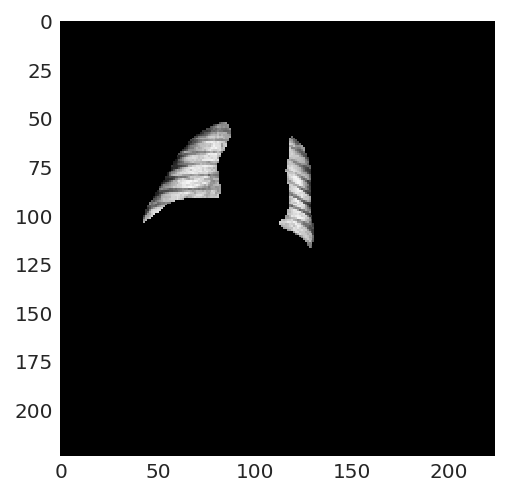

In [4]:
plt.imshow(rv_3ch(img_path_list[1], mask_path_list[1], (224,224)))

In [85]:
X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
    X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))
#       X[i][:][:][:] = cvt_crop(crop_list[i], (224,224)).astype(np.uint8)
    
y = np.array(data['diagnosis'])

In [86]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

MemoryError: Unable to allocate 3.59 GiB for an array with shape (3200, 224, 224, 3) and data type float64

In [24]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [25]:
print(Xtr.shape ,'/', Ytr.shape ,'/', Ytr_c.shape)
print(Xva.shape ,'/', Yva.shape ,'/', Yva_c.shape)
print(Xtst.shape ,'/', Ytst.shape ,'/', Ytst_c.shape)

(3200, 224, 224, 3) / (3200,) / (3200, 7)
(400, 224, 224, 3) / (400,) / (400, 7)
(400, 224, 224, 3) / (400,) / (400, 7)


In [11]:
del X

In [28]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=32,
                                    shuffle=True)
validation_generator = image_datagen.flow(x=Xva,y=Yva_c,
                                         batch_size=32,
                                         shuffle=True)


<module 'math' from '/opt/conda/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

In [64]:
from tensorflow.python.keras import backend as K
import tensorflow.python as tf
from sklearn.metrics import classification_report



def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1_score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score


def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)



class_weight = {0:0.571428563,
                1:1.397990367,
                2:4.617604545,
                3:1.662337636,
                4:0.892857129,
                5:0.571428563,
                6:1.181247674}


chexnet_model.compile( 
    optimizer= 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy',recall,precision,f1_score])

In [ ]:
# optimizer => nadm 으로 주고 (또 adamx)
# loss function => 바꿔보고(커스터마이징?)
# 에포크 높여보고.(배치사이즈도 줄여보고?)
# loss => f1 function 으로 대체.

# tf.python.astype.cast <=

In [65]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint


es = EarlyStopping( monitor='val_f1score',
                min_delta=0, 
                patience=0, 
                verbose=0, 
                mode='auto', 
                baseline=None, 
                restore_best_weights=False )

checkpointer = ModelCheckpoint('/home/ncp/workspace/chex_model_ver2_2.hdf5', monitor='val_f1score' ,
                               mode='max', verbose=1,save_best_only=True ,save_weights_only=False)



In [ ]:
# chexnet_model.compile(optimizer='nadam', loss='binary_crossentropy',metrics=['acc'])
import tensorflow as tf

# history = chexnet_model.fit(Xtr,Ytr_c, validation_data=[Xva,Yva_c],batch_size=3, epochs=100, callbacks=[checkpointer])
history2 = chexnet_model.fit_generator(train_generator, validation_data=validation_generator, 
                                       epochs=150, steps_per_epoch = 3, class_weight = class_weight,
                                       callbacks=[checkpointer],verbose=1)

In [ ]:
# evaluate model with sklearn
predictions_last_epoch = chexnet_model.predict(Xtst, batch_size=batch_size, verbose=1)
target_names = [0,1,2,3,4,5,6]
predicted_classes = np.argmax(predictions_last_epoch, axis=1)
print('\n')
print(classification_report(y_test, predicted_classes, 
        target_names=target_names, digits = 6))

In [69]:
pred = chexnet_model.predict(Xtst)

In [70]:
pred[0]

array([2.3195436e-04, 1.3303141e-02, 1.4812853e-09, 1.6751164e-09,
       9.8634303e-01, 1.1211360e-04, 9.8040418e-06], dtype=float32)

In [71]:
_loss, _acc, _precision, _recall, _f1score = chexnet_model.evaluate(Xtst, Ytst_c, batch_size=32, verbose=1)
print('loss: {:.3f}, accuracy: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _precision, _recall, _f1score))

400/400 [==============================] - 2s 5ms/sample - loss: 3.3684 - acc: 0.5225 - recall: 0.5120 - precision: 0.5215 - f1_score: 0.5167
loss: 3.368, accuracy: 0.522, precision: 0.512, recall: 0.522, f1score: 0.517


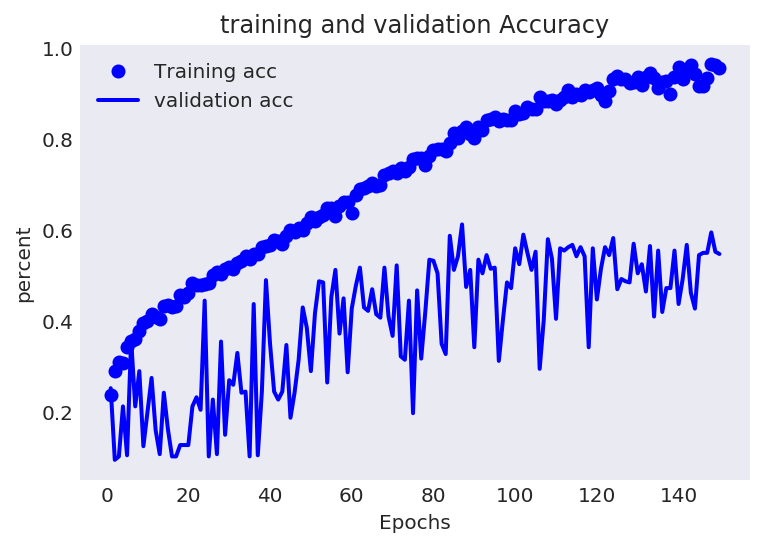

In [72]:
import matplotlib.pyplot as plt
loss = history2.history['loss']
val_loss = history2.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

# plt.plot(epochs, loss, 'bo', label = 'Training loss', color='red')
# plt.plot(epochs, val_loss, 'b', label = 'validation loss', color='red')
# plt.title('training and validation loss')


acc= history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('percent')
plt.legend()
plt.show()

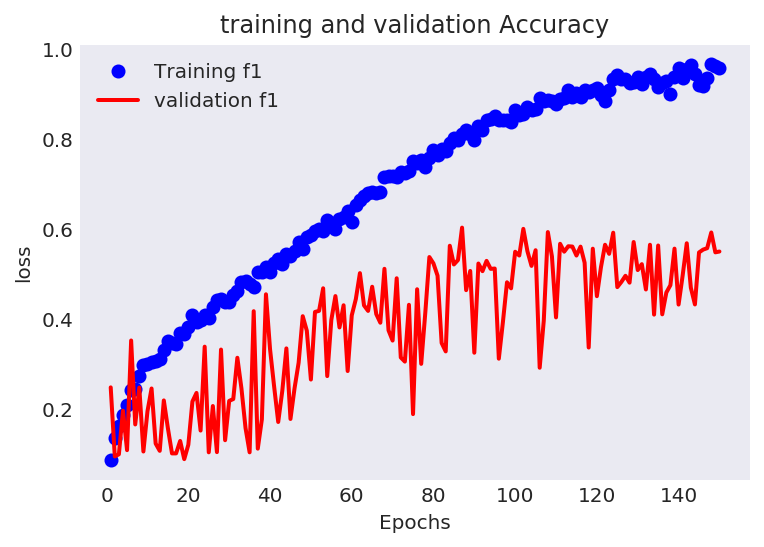

In [76]:
plt.clf()
f1= history2.history['f1_score']
val_f1 = history2.history['val_f1_score']
val_pre= history2.history['val_precision']
val_recall = history2.history['val_recall']
plt.plot(epochs, f1, 'bo', label='Training f1')
plt.plot(epochs, val_f1, 'b', label = 'validation f1', color='red')
# plt.plot(epochs, val_pre, 'b', label='precision' , color='green')
# plt.plot(epochs, val_recall, 'b', label = 'recall', color='green')

plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [44]:
pred = chexnet_model.predict(Xtst)

In [77]:
Ytst_c[0]

array([0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [25]:
pred[0]

array([9.9174540e-05, 5.4857442e-03, 7.5809264e-13, 2.2627814e-15,
       9.9433762e-01, 7.7484736e-05, 5.5066303e-12], dtype=float32)

In [78]:
ytst_a = np.asarray(Ytst_c).argmax(axis=1)
pred_a = np.asarray(pred).argmax(axis=1)

In [50]:
# from sklearn.metrics import classification_report

# predictions_last_epoch = chexnet_model.predict(Xtst, batch_size=16, verbose=1)
# target_names = [0,1,2,3,4,5,6]
# predicted_classes = np.argmax(predictions_last_epoch, axis=1)
# print('\n')

# print(classification_report(Ytst_c, predicted_classes, 
#         target_names=target_names))

In [79]:
from sklearn.metrics import f1_score

f1_score(ytst_a, pred_a, average='macro')

0.44375728890139793

In [80]:
from sklearn.metrics import accuracy_score

accuracy_score(ytst_a, pred_a)

0.5225

In [82]:
from sklearn.metrics import confusion_matrix

predictions_one_hot = chexnet_model.predict(Xtst)
cm = confusion_matrix(Ytst_c.argmax(axis=1), predictions_one_hot.argmax(axis=1))
print(cm)

[[82  1  2  1  5  5  4]
 [ 8 17  0  1  7  5  3]
 [ 9  0  1  2  0  0  1]
 [21  2  0  7  0  1  3]
 [ 2  3  0  0 55  2  2]
 [53  1  0  2  9 21 14]
 [17  0  0  1  0  4 26]]


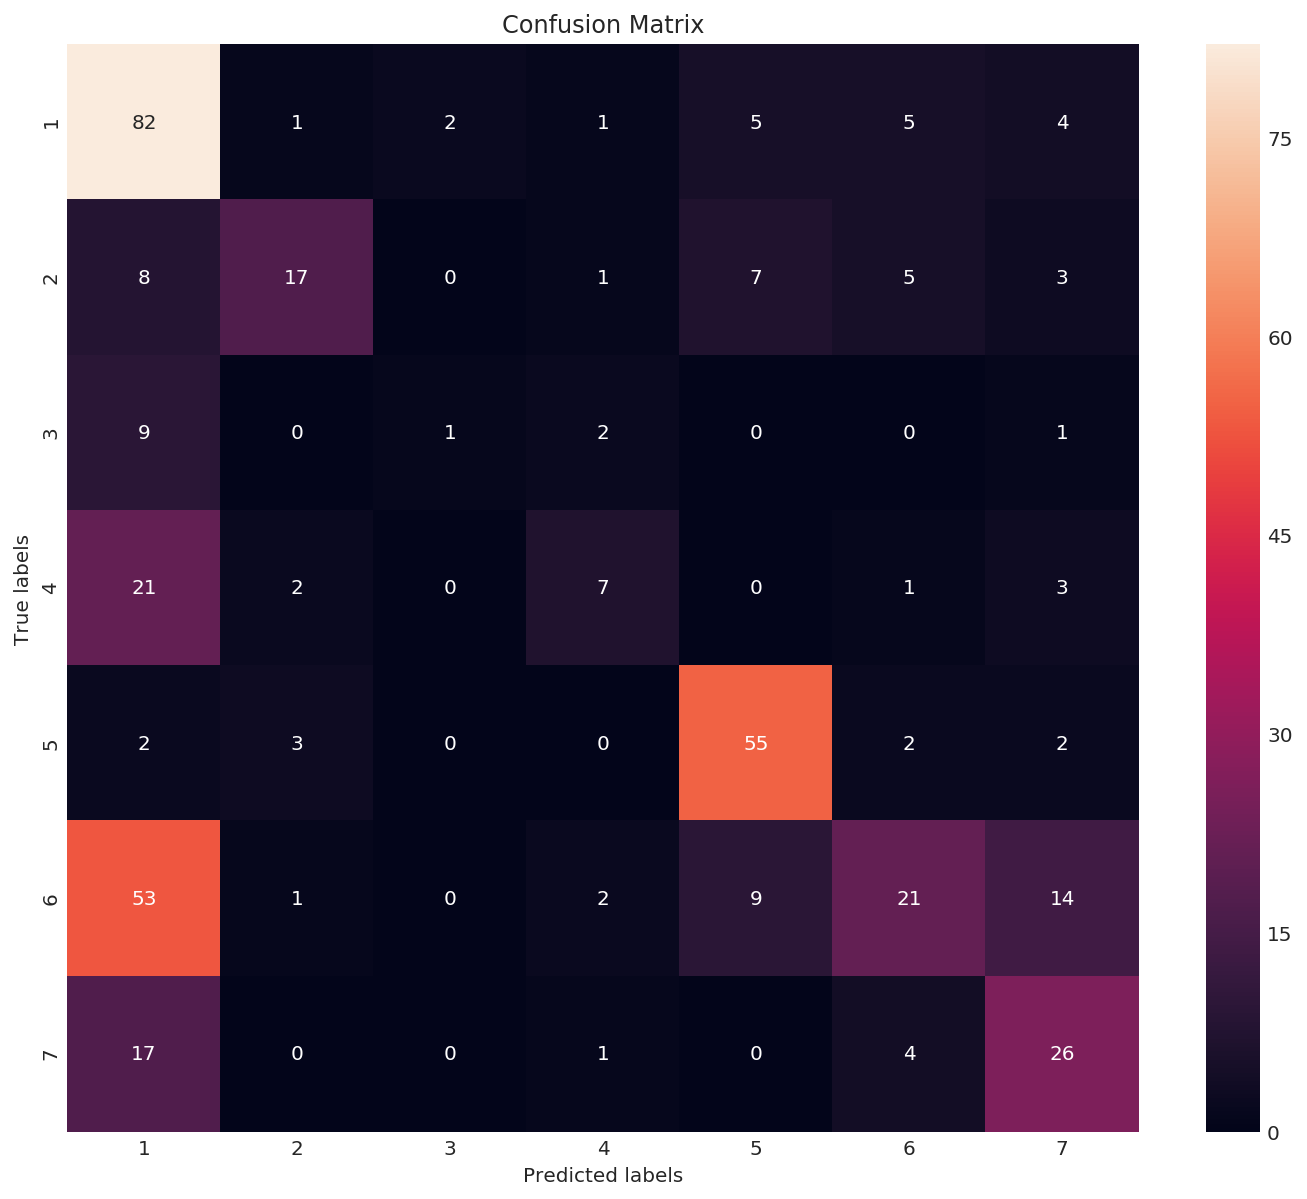

<Figure size 1080x720 with 0 Axes>

In [83]:
import seaborn as sns


T5_lables = ['1','2','3','4','5','6','7']    

plt.figure(figsize=(12,10))

ax= plt.subplot()

plt.figure(figsize=(15,10))
cm = confusion_matrix(np.asarray(Ytst_c).argmax(axis=1), np.asarray(pred).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


# 승해

In [84]:
# class별로 f1score
# https://datascience.stackexchange.com/questions/58822/how-do-i-calculate-the-range-of-a-f1-score-from-a-confusion-matrix-of-3-class-a
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
import pandas as pd
from sklearn.metrics import classification_report

# y_true = [0, 1, 2, 2, 2]
# y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

print(classification_report(ytst_a, pred_a, target_names=target_names))
# aaa= pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names))
# aaa

              precision    recall  f1-score   support

     class 0       0.43      0.82      0.56       100
     class 1       0.71      0.41      0.52        41
     class 2       0.33      0.08      0.12        13
     class 3       0.50      0.21      0.29        34
     class 4       0.72      0.86      0.79        64
     class 5       0.55      0.21      0.30       100
     class 6       0.49      0.54      0.51        48

    accuracy                           0.52       400
   macro avg       0.53      0.45      0.44       400
weighted avg       0.55      0.52      0.49       400



In [52]:
pred_val = chexnet_model.predict(Xva)
yval_a = np.asarray(pred_val).argmax(axis=1)
pred_val_a = np.asarray(pred_val).argmax(axis=1)

import pandas as pd
from sklearn.metrics import classification_report


target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

print(classification_report(yval_a, pred_val_a, target_names=target_names))
# aaa= pd.DataFrame(classification_report(y_true, y_pred, target_names=target_names))
# aaa

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       167
     class 1       1.00      1.00      1.00        41
     class 2       1.00      1.00      1.00         2
     class 3       1.00      1.00      1.00         5
     class 4       1.00      1.00      1.00        51
     class 5       1.00      1.00      1.00        58
     class 6       1.00      1.00      1.00        76

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



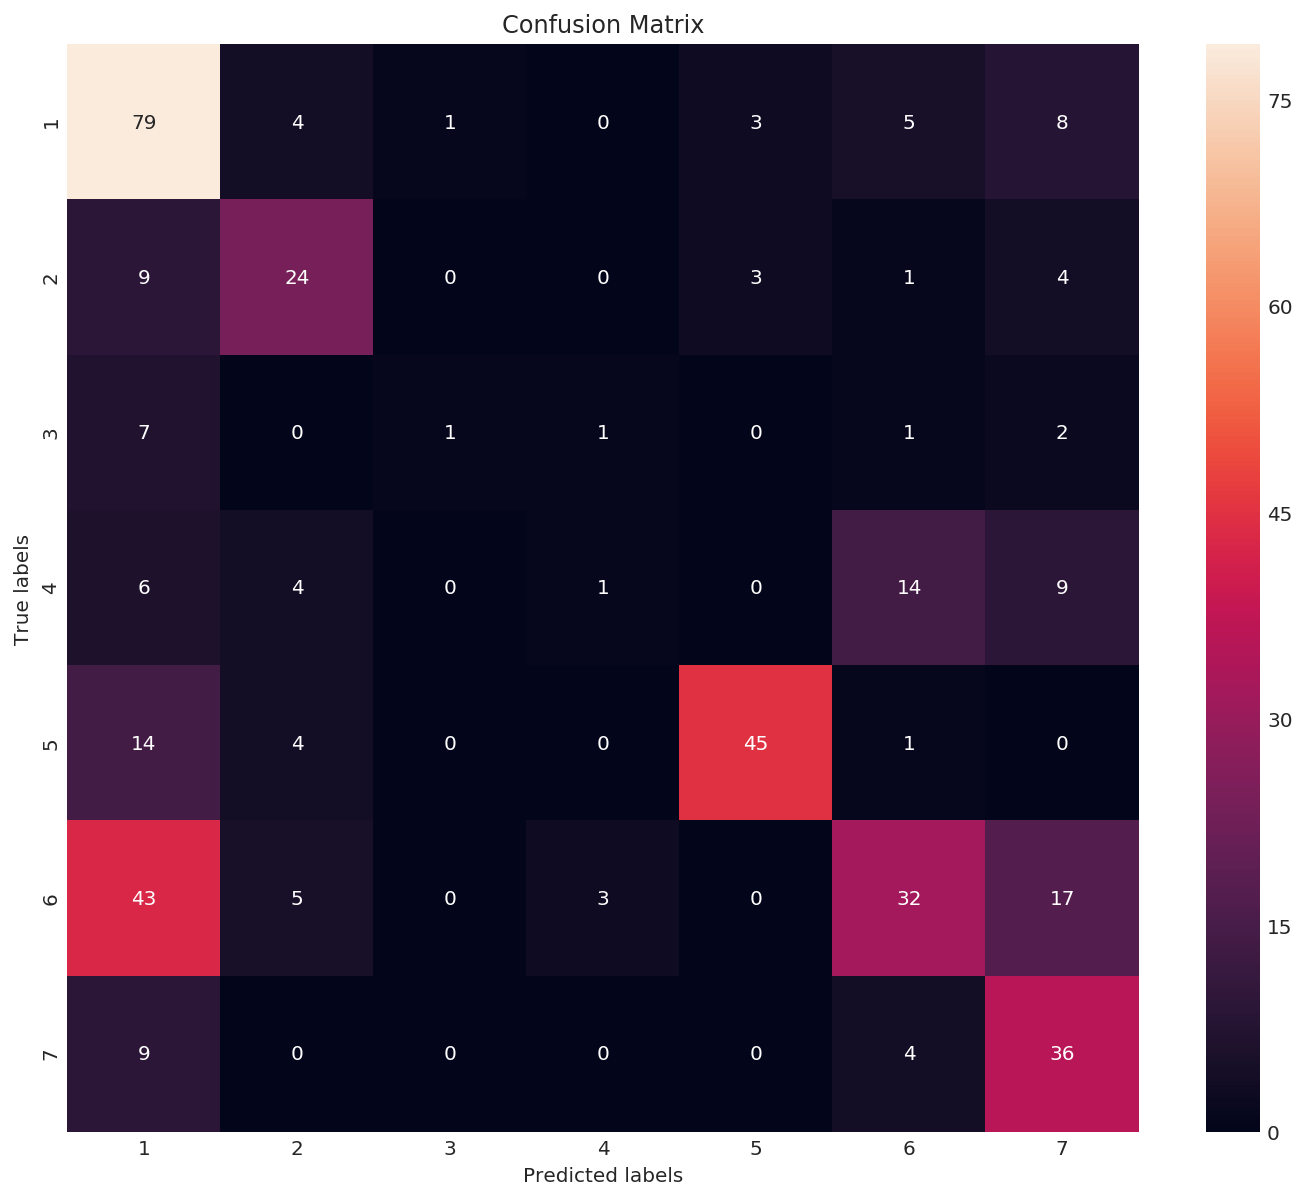

<Figure size 1080x720 with 0 Axes>

In [53]:
import seaborn as sns


T5_lables = ['1','2','3','4','5','6','7']    

plt.figure(figsize=(12,10))

ax= plt.subplot()

plt.figure(figsize=(15,10))
cm = confusion_matrix(np.asarray(Yva_c).argmax(axis=1), np.asarray(pred_val).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);


In [62]:
def get_confusion_matrix_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

TP, FP, FN, TN = get_confusion_matrix_values(ytst_a, pred_a)

In [67]:
conf = get_confusion_matrix_values(ytst_a, pred_a)
TP = conf[0,0]
FP = conf[0,1]
TN = conf[1,0]
FN = conf[1,1]

TypeError: tuple indices must be integers or slices, not tuple

In [73]:
TP + TN / TP+ TN+ FP+ FN

82.32727272727273

In [81]:
cm.shape

(7, 7)

In [90]:
cm

array([[55,  2,  3,  4,  3, 31,  2],
       [ 7, 18,  0,  0,  1, 15,  0],
       [ 1,  0,  3,  1,  0,  8,  0],
       [ 6,  0,  0,  5,  0, 21,  2],
       [21,  5,  0,  0, 28, 10,  0],
       [25,  1,  1,  5,  1, 63,  4],
       [ 9,  1,  1,  4,  0, 23, 10]])

In [ ]:
def matrix_one_class(x):
    c[]